# Diagnosing and Predicting Coronary Artery Disease
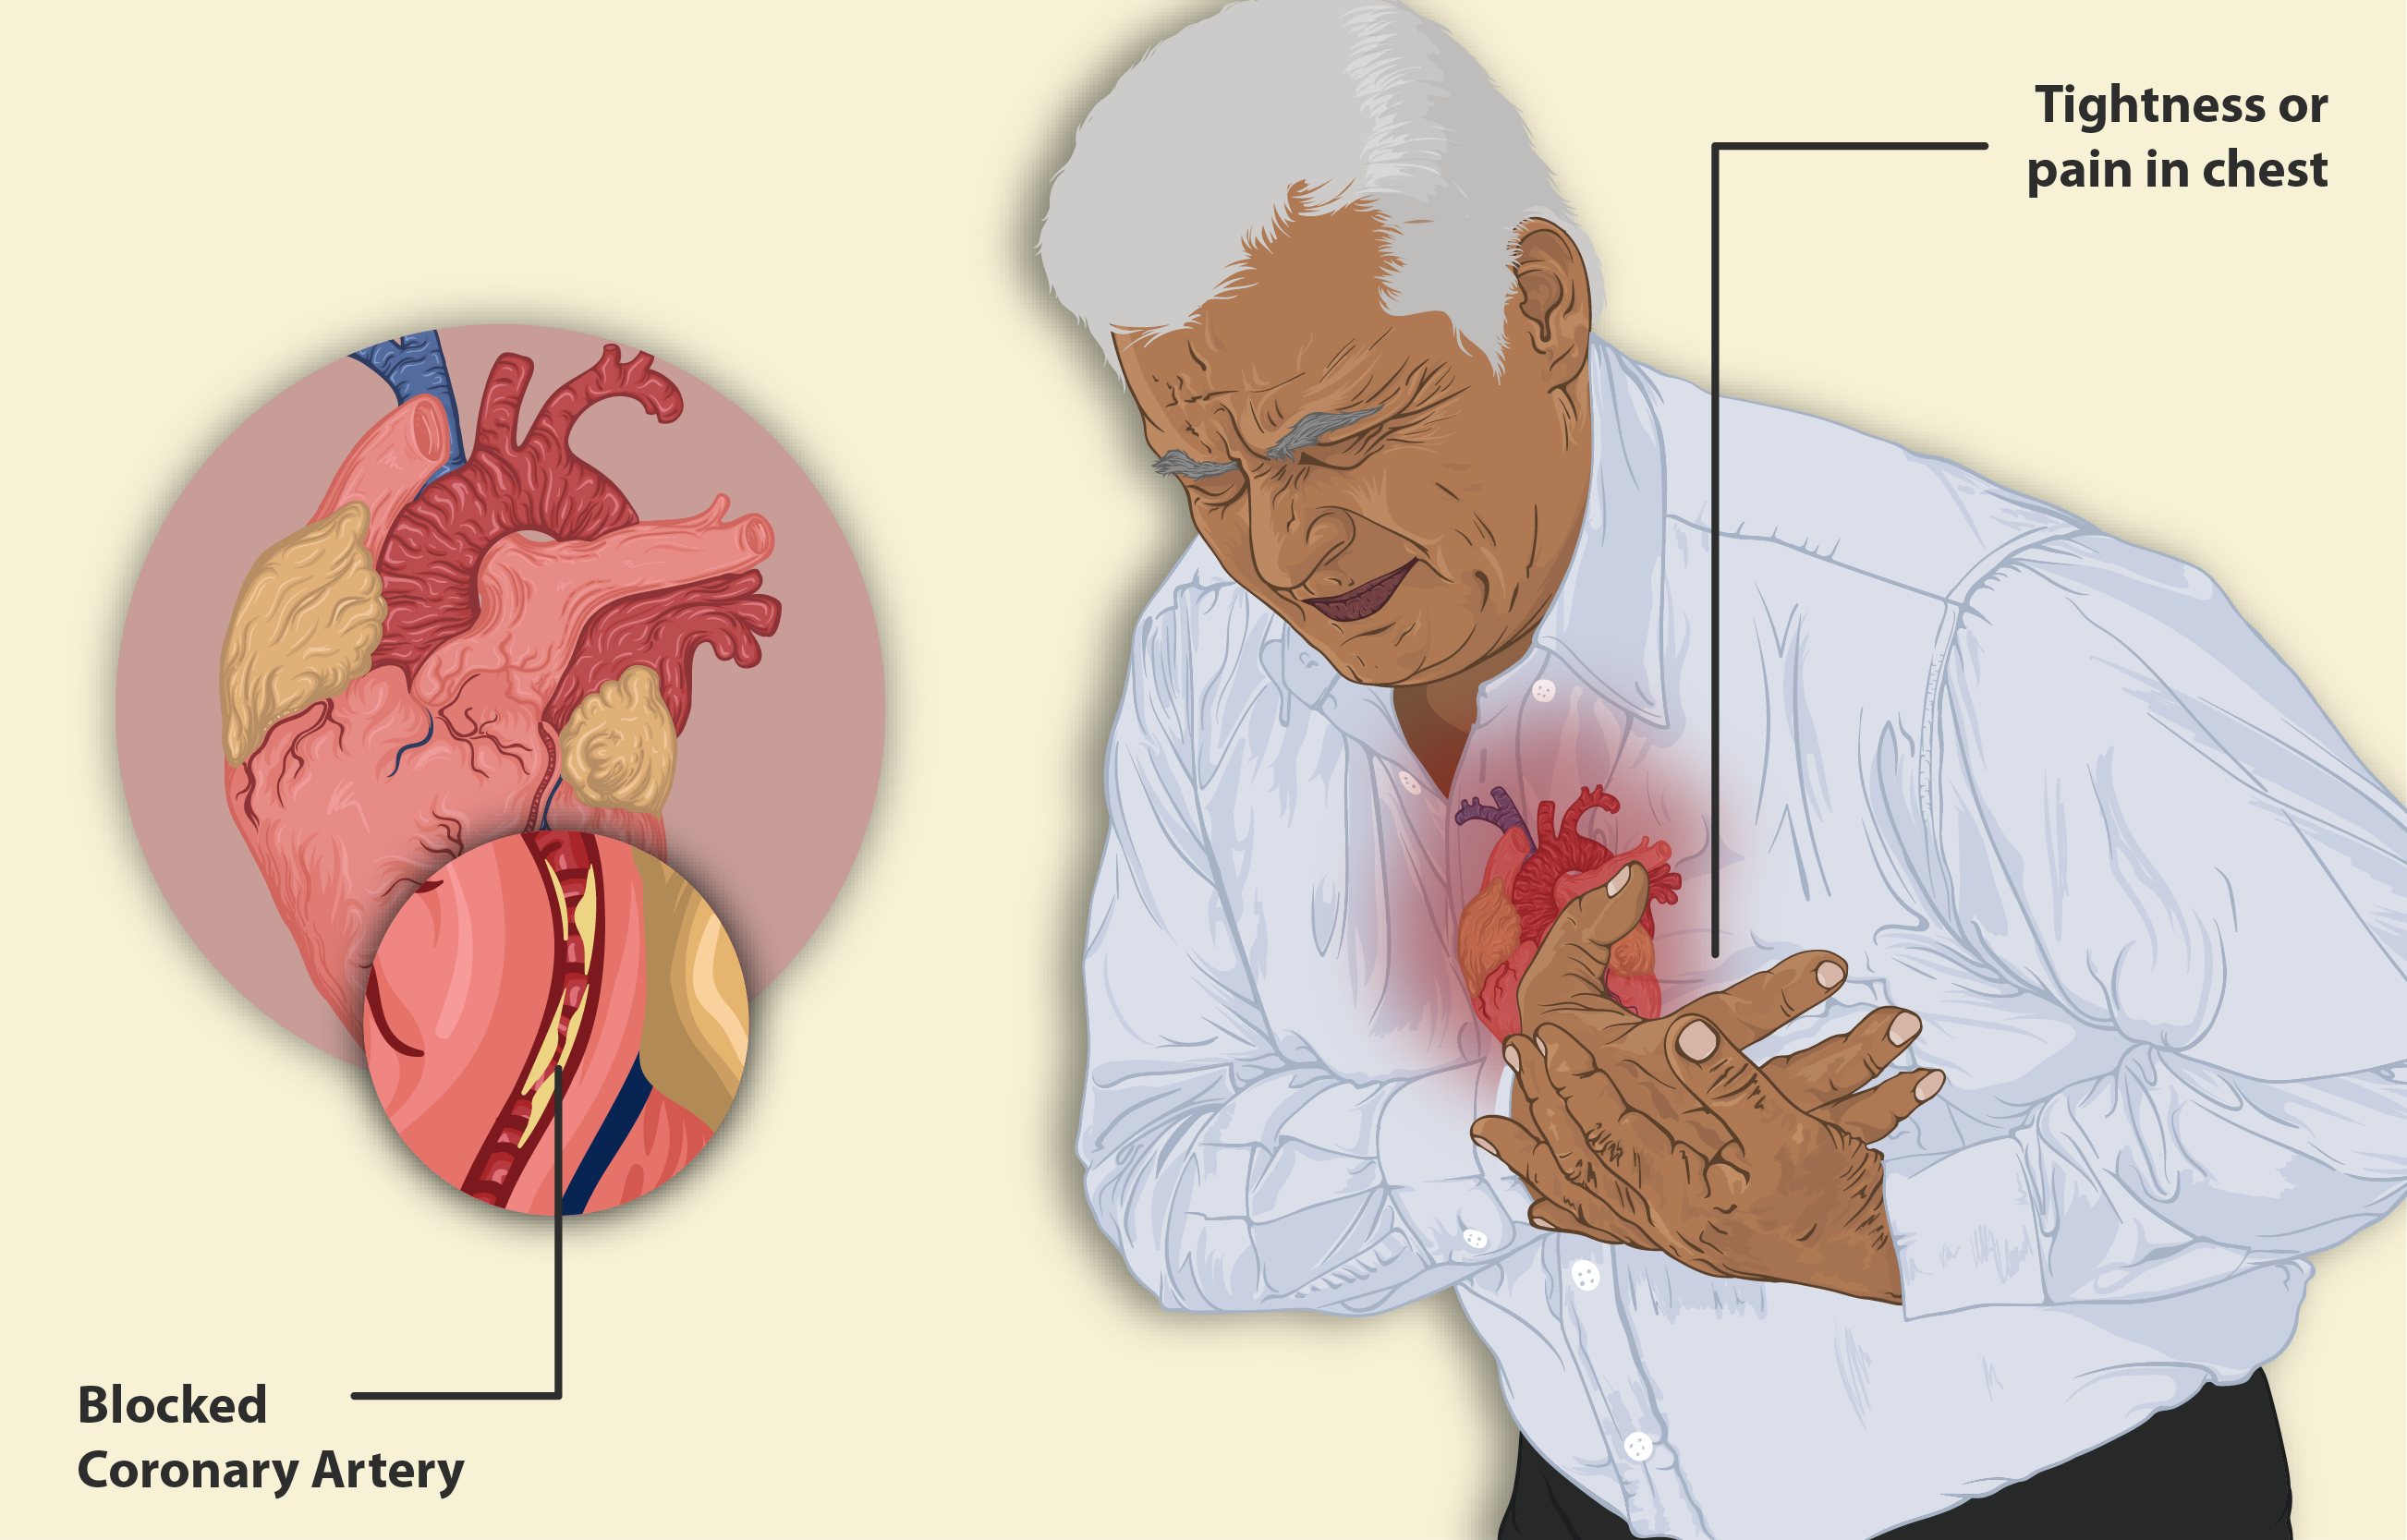

## Introduction: 

The coronary arteries are a vital part of the cardiovascular system as they are responsible for supplying the heart with sufficient blood, oxygen, and nutrients. These artieries are categorized into two main types - left and right - which both wrap around the heart and branch off to supply different regions of the heart with blood, thereby facilitating proper heart contraction and blood circulation throughout the body. 

Coronary Heart Disease (CAD) is a common heart condition that occurs when the movement of blood through the coronary arteries gets blocked or restricted by the buildup of plaque. Plaque is a collection of different substances found in the blood - including cholesterol, fat, calcium - which collect and buildup on the inner walls of the coronary arteries. This blood flow obstruction can lead to serious medical ailments, such as angina, heart attacks, reduced life expectancy, or even sudden death. For this reason, CAD is one of the leading causes of deaths worldwide and contributes to many of the cardiovascular diseases seen today. Given the serious implications of CAD and it's impact on quality of life, proactive measures (including early diagnosis, personalized treatment plans and mitigation strategies) are crucial to curtailing the progression of this disease. 

This CAD data analysis proposal outlines an approach to leverage data analysis techniques to develop an efficient predictive model to classify individuals based on whether they have CAD (and are at risk of developping this disease) or not. The research question being addressed is: **Can we predict the likelihood of a patient having Coronary Heart Disease based on the following clinical and diagnosal features: the number of major vessels colored by fluoroscopy (ca), thalassemia health condition level (thal), maximum heart rate(thalach), and exercise-induced angina (exang)?**

The dataset is obtained from https://archive.ics.uci.edu/dataset/45/heart+disease. This is a grouped dataset that contains observations from Cleveland, Hungary, Switzerland, and the Veterans Administration Medical center in Long Beach California. 

There are a total of 14 columns in this dataset, including: 
1. age : Age of the individual in years 
2. sex : Sex of the individual (0 = female, 1 = male)
3. cp : Chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic) 
4. trestbps: Resting blood pressure (in mmHg on admission the the hospital)  
5. chol : Serum cholestrol levels (in mg/dl)  
6. fbs : Fasting blood pressure > 120 mg/dl (0 = false, 1 = true) 
7. restecg : Resting electrocardiographic results (0 = normal, 1 = having ST-T abnormality, 2 = probable or definite left ventricular hypertrophy by Estes' criteria) 
8. thalach : Maximum heart rate achieved 
9. exang : Exercise induced angina (0 = false, 1 = true) 
10. oldpeak : ST depression induced by exercise relative to rest 
12. slope : Slope of the peak exercise ST segment ( 1 = upslope, 2 = flat, 3 = downslope) 
13. ca : Number of major vessels (0-3) colored by fluorosopy 
14. thal : thalassemia health condition level (3 = normal, 6 = fixed defect, 7 = reversable defect) 
15. num : Diagnosis of the heart disease


## Methods    

The dataset obtained from https://archive.ics.uci.edu/dataset/45/heart+disease is divided into 4 different regions, including Cleveland, Hungary, Switzerland, and Long Beach California. To develop a well-rounded and more accurate data interpretation and classififer, these regions will be combined into one dataframe. 

There will be 10 major steps in this data analysis: 

1. Reading the dataset: read the four separate dataframes corresponding to different geological datasets (Cleveland, Hungary, Switzerland, and California) into R. 

2. Data merging and initial cleaning: merge the four separate dataframes into one single dataframe, and ensure that all column headers and values are aligned properly. 

3. Data wrangling to create tidydata: transform the merged dataset according to tinydata conditions, ensuring each column is it's own column, each observation is it's own row, and each value is it's own cell. 

4. Creating a correlation plot: generate a correlation plot to identify the hidden relationships between num (a binary diagnosis of CAD 0 = false, 1 = true) and other variables in the dataset. This step is taken to help select the most relevent predicotrs for the classifier. 

5. Splitting the dataset into a training set and testing set: To ensure the model can be trained and tested/evaluated independently, the merged data set will be split. All further steps will be conducted on the training set. 

6. Data wrangling to select desired variables: further clean up and simplify the dataset to focus on the variables of interest - 1) number of major vessels colored by fluoroscopy (ca), 2) thalassemia health condition level (thal), 3) maximum heart rate(thalach), and 4) exercise-induced angina (exang)

7. K-Nearest Neighbors classifier: set up the knn classifier using cross-validation to find the optimal K value (# of nearest neighbors), then set up a workflow to start the model training process. 

8. Evaluate the effectiveness of the model: evaluate the k-nn classifier using the testing set from step 5 - accuracy, precision, and recall will be used to evaluate the model's performance. 

9. Visualization of the performance and predictions: create graphs of the model's predictions over the actual datapoints and their true 'label' to access how well the model is performing. 

10. Analysis of the results: in the context of CAD, the effectiveness of this classifier will be evaluated and potential applications and implications will be discussed. 


## Preliminary exploratory data analysis

### Loading libraries

In [66]:
library(tidyverse)    # allows data manipulation and visualization 
library(tidymodels)    # allows modelling and statistical analysis 
library(repr)    # string and binary representations of objects 
library(ggplot2)    # creates complex graphics
library(purrr)    # tools for functional programming and iterating functions 
library(stringr)    # string manipulation functions 
library(RColorBrewer)    # provides color schemes for graphics among other uses  
options(repr.matrix.max.rows = 6)    # limits output of dataframes to 6 rows
# library(ggcorrplot)    # imports the function to create the correlation plot


### Reading and Wrangling our dataset into Tidydata

In [67]:

# read each of the 4 datasets 

cl_url <- "https://raw.githubusercontent.com/kareenaka/dsci100project_kareenakak/main/data/heart_disease/processed.cleveland.data"
hu_url <- "https://raw.githubusercontent.com/kareenaka/dsci100project_kareenakak/main/data/heart_disease/processed.hungarian.data" 
sw_url <- "https://raw.githubusercontent.com/kareenaka/dsci100project_kareenakak/main/data/heart_disease/processed.switzerland.data"
va_url <- "https://raw.githubusercontent.com/kareenaka/dsci100project_kareenakak/main/data/heart_disease/processed.va.data"


data1 <- read.csv(cl_url, header = FALSE) |>
    map_df(function(x) gsub("?", NA, x, fixed = TRUE))
           
data2 <- read.csv(hu_url, header = FALSE) |> 
    map_df(function(x) gsub("?",NA,x, fixed = TRUE))
           
data3 <- read.csv(sw_url, header = FALSE) |> 
    map_df(function(x) gsub("?",NA,x, fixed = TRUE))
           
data4 <- read.csv(va_url, header = FALSE) |> 
    map_df(function(x) gsub("?",NA,x, fixed = TRUE))

heart_data <- 
    bind_rows(data1, data2, data3, data4) |>
    setNames(c("age", "sex", "cp", "trestbps", "chol", "fbs",
               "restecg", "thalach", "exang", "oldpeak", "slope", "ca",
               "thal", "num")) |>
    mutate_all(as.numeric) |>
    mutate(num = ifelse(is.na(num), NA, (num > 0)) |> as.numeric())

heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,NA,NA,6,1
58,1,4,NA,385,1,2,NA,NA,NA,NA,NA,NA,0
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


### Correlation plot

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 10)

# The R package corrplot is a tool which can help detect hidden patterns among variables 

corr_plot <- 
    heart_data |>
    cor(use="complete.obs") |>  # skips NA value rows
    ggcorrplot(outline.col = "white",
               type = "lower",
               lab = TRUE,
               lab_size = 5,
               tl.cex = 18,
               legend.title = "Correlation Coefficient\n") +
    labs(title = "Correlation Plot for Heart Data",
         caption = "\nFigure 1") +
    theme(legend.title = element_text(size = 18, face = "bold"),
          legend.text = element_text(size = 18),
          legend.key.size = unit(1, "cm"),
          plot.title = element_text(size = 20, hjust = 0.5),
          plot.caption = element_text(size = 15, hjust = 0.5))

corr_plot


### Splitting the data into a training and testing set 

In [68]:
# splitting the dataframe into a training_set (0.75) and a testing_set (0.25) 

set.seed(9999)

heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train
heart_test

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,1,4,158,170,0,1,138,1,0,NA,NA,NA,1
54,0,4,127,333,1,1,154,0,0,NA,NA,NA,1
55,1,4,122,223,1,1,100,0,0,NA,NA,6,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,1,4,160,254,1,1,108,1,3,2,NA,NA,1
46,1,4,134,310,0,0,126,0,0,NA,NA,3,1
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


### Understanding and summarizing the data

In [69]:
# How many obervations belong to patients with Coronary Artery Disease versus patients who do not have Coronary Artery Disease (the number of observations in each class)

data_per_class <- heart_train |> 
    group_by(num) |> 
    summarize(n = n()) 

data_per_class

num,n
<dbl>,<int>
0,308
1,381


In [70]:
# the max, mins, and means of the predictor variables used in this analysis

heart_summary_per_desired_column <- heart_train |> 
    group_by(num) |> 
    summarize(max_thalach = max(thalach, na.rm = TRUE), 
              min_thalach = min(thalach, na.rm = TRUE), 
              mean_thalach = mean(thalach, na.rm = TRUE), 
              max_exang = max(thalach, na.rm = TRUE),
              min_exang = min(thalach, na.rm = TRUE),
              mean_exang = mean(thalach, na.rm = TRUE),
              max_ca = max(ca, na.rm = TRUE), 
              min_ca = min(ca, na.rm = TRUE), 
              mean_ca = mean(ca, na.rm = TRUE), 
              max_thal = max(thal, na.rm = TRUE), 
              min_thal = min(thal, na.rm = TRUE), 
              mean_thal = mean(thal, na.rm = TRUE)) 

heart_summary_per_desired_column


num,max_thalach,min_thalach,mean_thalach,max_exang,min_exang,mean_exang,max_ca,min_ca,mean_ca,max_thal,min_thal,mean_thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,194,69,149.0377,194,69,149.0377,3,0,0.2809917,7,3,4.066667
1,195,60,128.8230,195,60,128.8230,3,0,1.0769231,7,3,5.977901


In [71]:
# How many rows have missing data (excluded in the above 2 coding cells 

num_rows_without_na <- nrow(na.omit(heart_train)) 

num_rows_with_na <- nrow(heart_train) - num_rows_without_na

na_summary <- tibble(
    "Number of rows without NA values" = num_rows_without_na,
    "Number of rows with NA values" = num_rows_with_na) 

na_summary

Number of rows without NA values,Number of rows with NA values
<int>,<int>
220,469


Warning message:
“Removed 41 rows containing non-finite outside the scale range (`stat_bin()`).”


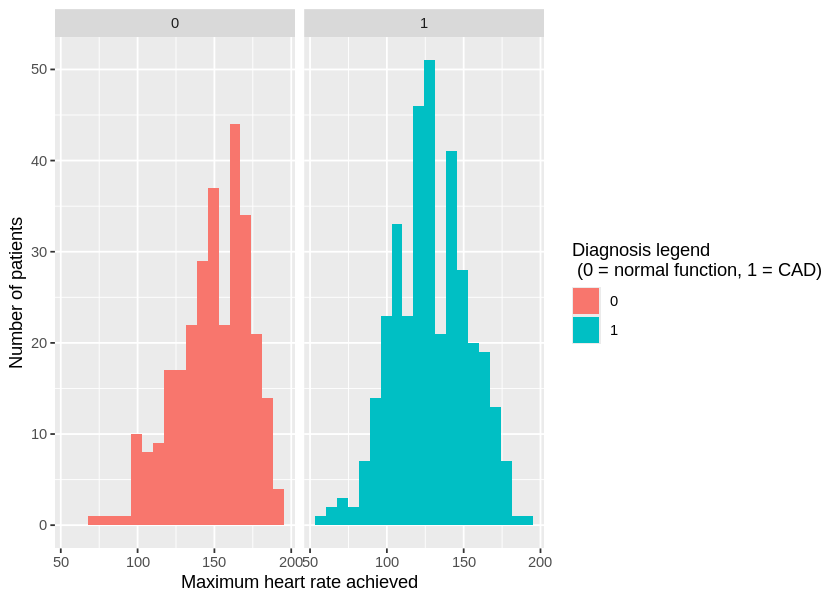

In [117]:
options(repr.plot.width = 7, repr.plot.height = 5)

thalach_histogram <- heart_train |> 
    ggplot(aes(x = thalach, fill = as_factor(num))) + 
    geom_histogram(bins = 20) + 
    labs(x = "Maximum heart rate achieved", y = "Number of patients", fill = "Diagnosis legend \n (0 = normal function, 1 = CAD)") + 
    facet_grid(cols = vars(num))

thalach_histogram

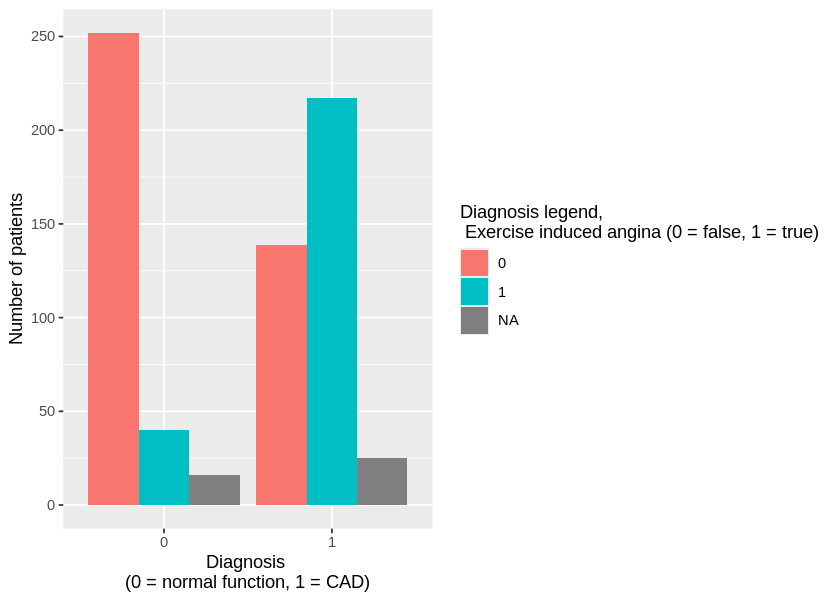

In [118]:
options(repr.plot.width = 7, repr.plot.height = 5)

exang_bar <- ggplot(heart_train, aes(x = as_factor(num), fill = as_factor(exang))) + 
    geom_bar(position = "dodge", stat = "count") + 
    labs(x = "Diagnosis \n(0 = normal function, 1 = CAD)", y = "Number of patients", fill = "Diagnosis legend, \n Exercise induced angina (0 = false, 1 = true)")  

exang_bar 

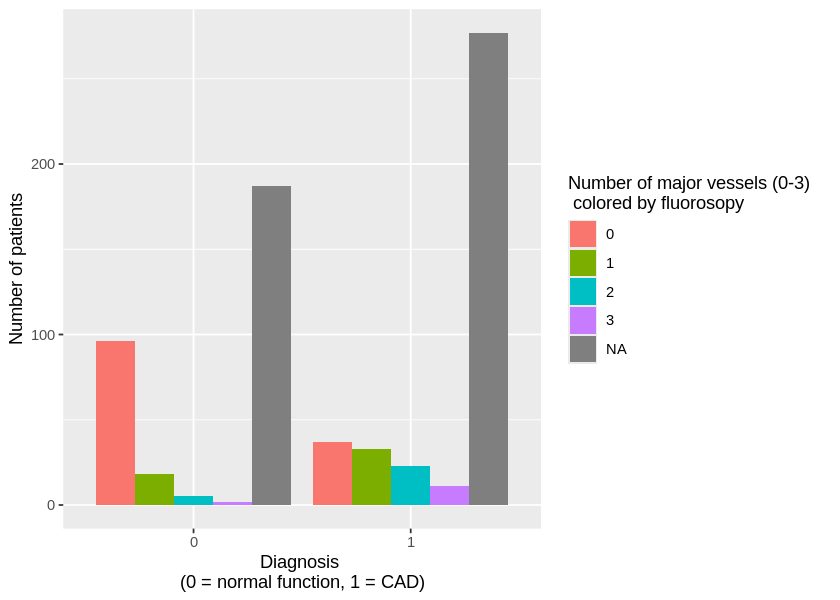

In [120]:
options(repr.plot.width = 7, repr.plot.height = 5)

ca_bar <- ggplot(heart_train, aes(x = as_factor(num), fill = as_factor(ca))) + 
    geom_bar(position = "dodge", stat = "count") + 
    labs(x = "Diagnosis \n(0 = normal function, 1 = CAD)", y = "Number of patients", fill = "Number of major vessels (0-3) \n colored by fluorosopy") 

ca_bar

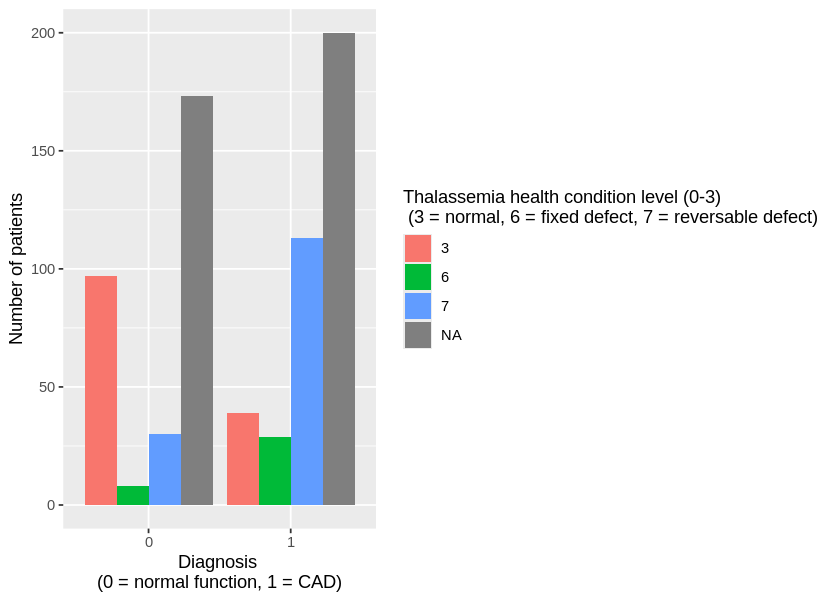

In [121]:
options(repr.plot.width = 7, repr.plot.height = 5)

thal_bar <- ggplot(heart_train, aes(x = as_factor(num), fill = as_factor(thal))) + 
    geom_bar(position = "dodge", stat = "count") + 
    labs(x = "Diagnosis \n(0 = normal function, 1 = CAD)", y = "Number of patients", fill = "Thalassemia health condition level (0-3) \n (3 = normal, 6 = fixed defect, 7 = reversable defect)")  

thal_bar

## Expected outcomes and significance of findings: 

Through proper data analysis, visualization, and knn-classifcation techniques, I anticipate to find that patients who are older, have high serum cholestrol levels (mg/dl), and have low maximum heart rates will likely be diagnosed with CAD or at least be highly likely to develop this medical condition.  

The findings from this project could have significant future implications for public health care and personal practices. By building a classifier that can accurately diagnose patients with Coronary Artery Disease (CAD), healthcare professionals would be able to identify and diagnose people with CAD, implement targetted interventions, and plan personalized treatment plans much more quickly and with confidence. This could result in a reduction of CAD and CAD-related health problems, thereby increasing the quality of life for many affected people all around the world. 


This data analysis could spark the investigation of more questions, including: 
1) Which combinations of factors contribute the most to CAD? 
2) Is there a way to diagnose if someone has a genetic predisposition to CAD through the data collected, or would further research be needed?
3) Can the region in which a patient lives in impact the severity of their disease? 


## Bibliography




**FORMAT PROPERLY !!**



- https://www.ncbi.nlm.nih.gov/books/NBK564304/
- https://www.mayoclinic.org/diseases-conditions/coronary-artery-disease/symptoms-causes/syc-20350613#:~:text=CAD%20happens%20when%20coronary%20arteries,or%20even%20a%20heart%20attack.

